# Introduction to Deep Learning for Particle Physics - Part1

# $e/\gamma$ ECAL Shower Classification with ML

### Introduction

<img src="./images/cms_overall.png" alt="CMS Overview" width="40%" style="float:left" />

<img src="./images/cms_layout_transverse.png" alt="CMS Transverse Layout" width="55%" style="float:right" />

<!-- ![CMS Overview](./images/cms_overall.png)
![CMS Transverse Layout](./images/cms_layout_transverse.png) -->

*Figure*: **[1]** Overview of the CMS detector (*left*) and **[2]** Transverse layout of the CMS detector (*right*)

The Large Hadron Collider (LHC) at CERN smashes protons together at close to the speed of light. Some of the collision energy is turned into mass, creating new particles which are observed in the Compact Muon Solenoid (CMS) particle detector **[1]**. Different layers of the CMS detector **[2]** measure different particles and phenomena produced in the high-energy collision, which are later analyzed to reconstruct a picture of events at the heart of the collision. Electromagnetic calorimeter (ECAL) at the CMS detector measures electrons ($e$) and photons ($\gamma$) from their energy deposits, called "shower", in the calorimeter. 

With the measurements from ECAL, combined with those from the previous layer of the detector, silicon tracker, physicists are able to identify and reconstruct the electrons and photons. However, with the information of ECAL shower only, it is not possible with the "traditional" method to identify the particle as electron or photon. 

In this project, we aim to distinguish electron vs. photon showers using Deep Learning algorithm, with a convolutional neural network (CNN) as a classifier. While the two are nearly indistinguishable in the ECAL, the electron shower is very slightly skewed along the φ direction due to its interaction with the B-field of the CMS solenoid. This effect, however, is very subtle and not easily discernible by eye. Thus, e/γ classification is a very stringent test of how sensitive CNN algorithms are to subtle variations in the data.

### Overview of ECAL

<img src="./images/ECAL_yz.png" alt="ECAL y-z Plane View" width=48% style="float:right"/>

<img src="./images/ECAL_overview.png" alt="ECAL Overview" width=42% style="float:left"/>

The CMS electromagnetic calorimeter (ECAL) is made up of 75,848 homogeneous lead tungstate ($PbWO_{4}$) crystals. When electrons and photons pass through the crystal, it "scintillates" and produces light in proportion to the particle's energy. The photodetectors, glued onto the back of each of the crystals, detect the scintillation light and convert it to an electrical signal that is amplified and sent for analysis. 

The crystals are arranged in a central barrel section with pseudorapidity coverage up to $\eta$ = 1.479, closed by two endcaps extending the coverage up to $\eta$ = 3.0. For extra spatial precision, the ECAL also contains Preshower detectors that sit in front of the endcaps. The cylindrical barrel consists of 61,200 crystals, arranged in a grid of 170 (pseudorapidity, $\eta$) x 360 (azimuthal angle in the transverse plane, $\phi$). Each crystal spans an angular area of 0.0174 x 0.0174. A single crystal is represented in the image data as a single pixel, with the energy deposited in the crystal corresponding to the intensity of that pixel.

In this project, we will use ECAL shower data from the barrel section only. 

### Now, let's work with data!

We will use single electron and single photon particle guns, generated with uniform pT = (15, 100) GeV, |$\eta$| < 1.4, and -π < $\phi$ < π. These are simulated through the full 2017 CMS detector, accounting for the effects of the preceding tracker layers on the e/γ shower. Energy deposits from simulated pileup are overlaid as well. 
1. **Electron** data: *'SingleElectronPt15To100_pythia8_PU2017_MINIAODSIM.**'*
2. **Photon** data: *'SinglePhotonPt15To100_pythia8_PU2017_MINIAODSIM.**'*

In [1]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pyarrow as pa
import pyarrow.parquet as pq
import glob
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from utils import *

Welcome to JupyROOT 6.22/06


In [2]:
# Import data

# electron data
elec = glob.glob('./data/SingleElectronPt15To100_pythia8_PU2017_MINIAODSIM.parquet.[1-8]')
elec = [pq.ParquetFile(i) for i in elec]

nEntries_elec = [f.num_row_groups for f in elec] # total event number in the electron data files

# photon data
pho = glob.glob('./data/SinglePhotonPt15To100_pythia8_PU2017_MINIAODSIM.parquet.[1-8]')
pho = [pq.ParquetFile(i) for i in pho]

nEntries_pho = [f.num_row_groups for f in pho] # total event number in the photon data files
    
print(nEntries_elec, nEntries_pho)

[44210, 44450, 44004, 44466, 44190, 44216, 44328, 44456] [76764, 77106, 77043, 76788, 76922, 76877, 76881, 77143]


### Sneak peek into the physics variables in the data
### 1. Overview of features
#### Plot histograms of features

In [3]:
i = 0
d = elec[0].read_row_group(i).to_pydict() # python dict of entry i
print(d.keys())

d = pho[0].read_row_group(i).to_pydict() # python dict of entry i
print(d.keys())

odict_keys(['idx', 'pt', 'pho_id', 'pi0_p4', 'm', 'Xtz', 'ieta', 'iphi', 'pho_p4', 'X', 'dR'])
odict_keys(['idx', 'pt', 'pho_id', 'pi0_p4', 'm', 'Xtz', 'ieta', 'iphi', 'pho_p4', 'X', 'dR'])


In [4]:
elec_ids = []
pho_ids = []
energies = []
nEles = 40_000

for i in tqdm(range(len(elec)), total=len(elec)):
    for k in tqdm(range(nEles), total=nEles):
        d = elec[i].read_row_group(k).to_pydict() # python dict of entry i
        dd = pho[i].read_row_group(k).to_pydict()
        elec_ids.append(d['pho_id'][0])
        pho_ids.append(dd['pho_id'][0])

elec_ids = np.array(elec_ids)
pho_ids = np.array(pho_ids)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

In [5]:
# scale the data
scaler = StandardScaler()
elec_scaler = scaler.fit(elec_ids)
scaled_elec_ids = elec_scaler.transform(elec_ids)
pho_scaler = scaler.fit(pho_ids)
scaled_pho_ids = pho_scaler.transform(pho_ids)

In [6]:
pho_id_vars = ['r9',
          'sieie',
          'phoIso',
          'chgIso',
          'chgIsoWrongVtx',
          'Eraw',
          'phiWidth',
          'etaWidth',
          'scEta',
          'sieip',
          's4']
assert len(pho_id_vars) == len(scaled_elec_ids[0])
assert len(pho_id_vars) == len(scaled_pho_ids[0])
elec_ids = {pho_id_vars[i]:np.array(scaled_elec_ids[:,i]) for i in range(len(pho_id_vars))}
pho_ids = {pho_id_vars[i]:np.array(scaled_pho_ids[:,i]) for i in range(len(pho_id_vars))}


"\nelec_ids2 = {'r9': np.array([item[0] for item in scaled_elec_ids]),\n          'sieie': np.array([item[1] for item in scaled_elec_ids]),\n          'phoIso':np.array([item[2] for item in scaled_elec_ids]),\n          'chgIso':np.array([item[3] for item in scaled_elec_ids]),\n          'chgIsoWrongVtx':np.array([item[4] for item in scaled_elec_ids]),\n          'Eraw':np.array([item[5] for item in scaled_elec_ids]),\n          'phiWidth':np.array([item[6] for item in scaled_elec_ids]),\n          'etaWidth':np.array([item[7] for item in scaled_elec_ids]),\n          'scEta':np.array([item[8] for item in scaled_elec_ids]),\n          'sieip':np.array([item[9] for item in scaled_elec_ids]),\n          's4':np.array([item[10] for item in scaled_elec_ids])}\n\npho_ids2 = {'r9': np.array([item[0] for item in scaled_pho_ids]),\n          'sieie': np.array([item[1] for item in scaled_pho_ids]),\n          'phoIso':np.array([item[2] for item in scaled_pho_ids]),\n          'chgIso':np.array(

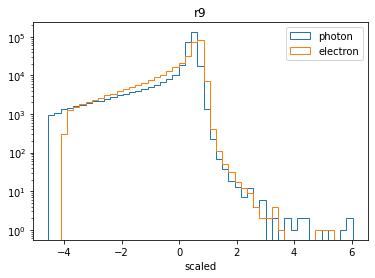

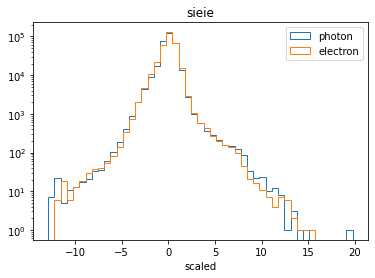

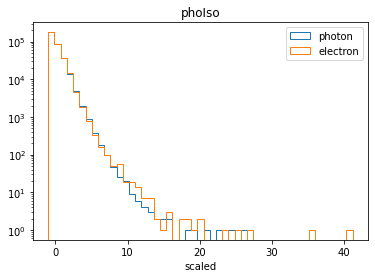

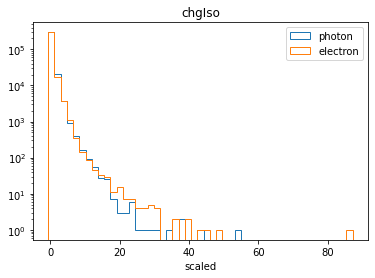

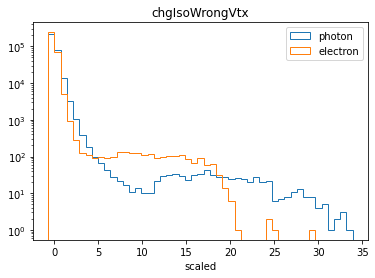

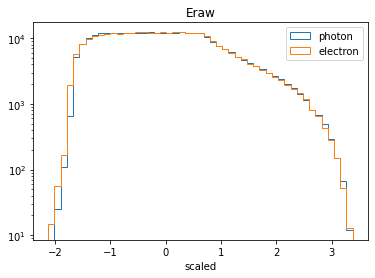

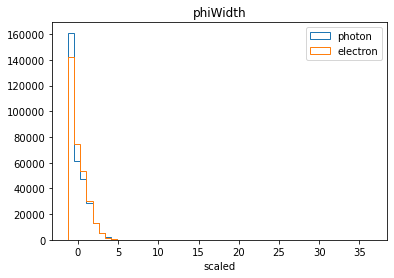

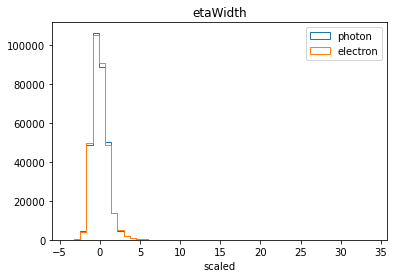

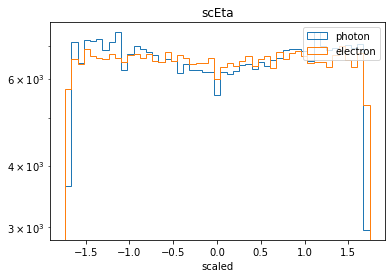

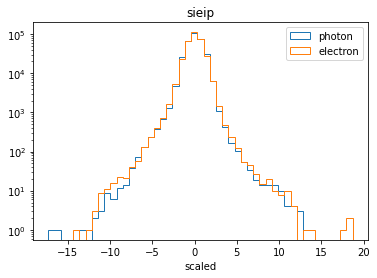

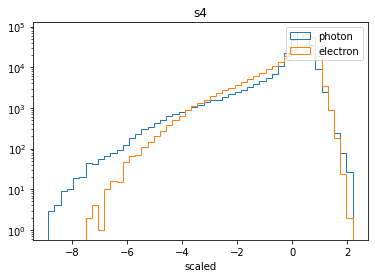

In [10]:
# plot histograms of features
for i in range(len(list(pho_ids.keys()))):    
    pho_min_val, pho_max_val = min(pho_ids[pho_id_vars[i]]), max(pho_ids[pho_id_vars[i]])
    elec_min_val, elec_max_val = min(elec_ids[pho_id_vars[i]]), max(elec_ids[pho_id_vars[i]])
    
    min_val = min(pho_min_val, elec_min_val)
    max_val = max(pho_max_val, elec_max_val)
    
    plt.hist(pho_ids[pho_id_vars[i]], bins=np.linspace(min_val, max_val, 50), label='photon', histtype='step')
    plt.hist(elec_ids[pho_id_vars[i]], bins=np.linspace(min_val, max_val, 50), label='electron', histtype='step')
    plt.legend()
    plt.title(pho_id_vars[i]) #plt.title(k)
    plt.xlabel('scaled')
    plt.savefig('./images/hist/' + pho_id_vars[i] + '.png')
    
    if pho_id_vars[i] in ['phiWidth', 'etaWidth']:
        plt.yscale('linear')
    else:
        plt.yscale('log')
    
    plt.show()


The histograms of electromagnetic shower features show that electrons and photons have differences in some features such as phiWidth vs etaWidth. 

Electrons and photons are almost identical in etaWidth, but not phiWidth. The difference is cased by the magnetic field applied in the z direction in the tracker. Since electrons are negatively charged, they experience force toward $\phi$ direction. This difference appears on the 'phiWidth' and 'etaWidth'. 

### 2D ECAL Shower Image (32x32 window) for $e$ and $\gamma$
### Energy distribution in a shower for photons and electrons

ECAL system uses its own coordinate (i$\eta$, i$\phi$), based on the ordering of the crystals with respect to some reference. As dataset for classification, we will use 2D images of $e$/$\gamma$ shower constructed from 32 x 32 windows around the energy maximum of the particle shower. Before we feed the data to the classifier, let's plot and look at the shower image for electron events and photon events, respectively. 

In [9]:
# Plotting function
def plot_shower(img, title = '', doColorbar=True):
    fig, ax = plt.subplots()
    ax.imshow(np.zeros_like(img), cmap='hot_r', origin='lower')
    im = ax.imshow(img, cmap='hot_r', origin='lower', norm=LogNorm(vmin = 1e-2, vmax = 1e+2))

    if doColorbar:
        ax.figure.colorbar(im, ax=ax, fraction=0.045, pad=0.05, label='Energy [GeV]')
        plt.text(0.55, 0.8, r'$\mathbf{CMS}\;\mathit{Simulation}$', fontsize=14, transform=plt.gcf().transFigure) # (x,y) for x,y in (0.,1.) of fig dims
    else:
        plt.text(0.48, 0.8, r'$\mathbf{CMS}\;\mathit{Simulation}$', fontsize=14, transform=plt.gcf().transFigure) # (x,y) for x,y in (0.,1.) of fig dims

    # labels
    plt.xlabel(r"$\mathrm{i\phi}$", size=13)
    plt.ylabel(r"$\mathrm{i\eta}$", size=13)
    plt.title(title, fontsize=13)
    plt.show()

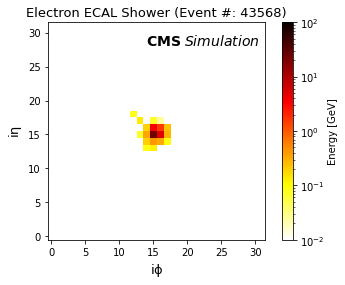

In [10]:
'''
Plot 2D ECAL shower image from ELECTRON data (SINGLE event)
'''

# Randomly pick a single event (event number n) from one of the data above
f = np.random.randint(0,len(elec))                # pick a file
n = np.random.randint(1, high=nEntries_elec[f])   # pick event number

# Get E/gamma shower image from the parquet table and convert it to 32x32 numpy array
X_elec = elec[f].read_row_group(n, 'X').to_pydict()['X']
X_elec = np.array(X_elec).reshape(-1,32)

# Plot in log
plot_shower(X_elec, title='Electron ECAL Shower (Event #: {})'.format(n))

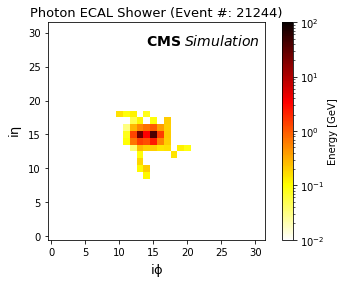

In [11]:
'''
Plot 2D ECAL shower image from PHOTON data (SINGLE event)
'''

# Randomly pick a single event (event number n) from one of the data above
f = np.random.randint(0,len(pho))                 # pick a file
n = np.random.randint(1, high=nEntries_elec[f])   # pick event number

# Get E/gamma shower image from the parquet table and convert it to 32x32 numpy array
X_pho = pho[f].read_row_group(n, 'X').to_pydict()['X']
X_pho = np.array(X_pho).reshape(-1,32)

# Plot in log
plot_shower(X_pho, title='Photon ECAL Shower (Event #: {})'.format(n))

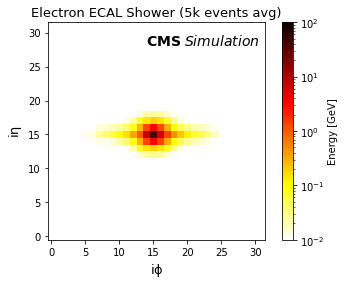

In [12]:
'''
Plot 2D ECAL shower image from ELECTRON data (Log Plot of 5k event AVG sum)
'''

shower = np.zeros([32,32])
for n in range(0,5000):
    # Get E/gamma shower image from the parquet table and convert it to 32x32 numpy array
    X = elec[0].read_row_group(n, 'X')
    X = X.to_pydict()['X']

    X = np.array(X).reshape(-1,32)

    shower += X

# Plot the image in 2d
shower /= 5000.
plot_shower(shower, title='Electron ECAL Shower (5k events avg)'.format(n))

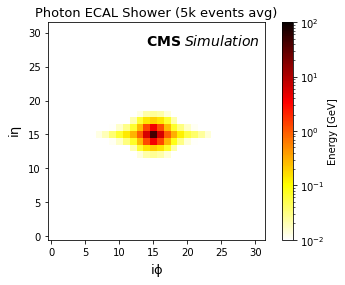

In [13]:
'''
Plot 2D ECAL shower image from PHOTON data (Log Plot of 5k event AVG sum)
'''

shower = np.zeros([32,32])
for n in range(0,5000):
    # Get E/gamma shower image from the parquet table and convert it to 32x32 numpy array
    X = pho[4].read_row_group(n, 'X')
    X = X.to_pydict()['X']

    X = np.array(X).reshape(-1,32)

    shower += X

# Plot the image in 2d
shower /= 5000.
plot_shower(shower, title='Photon ECAL Shower (5k events avg)'.format(n))

### Flatten the images and plot a histogram of energy distributions 

In [11]:
# plot energy 
# pick num events 
num_events = 40_000
print(f'num_events : {num_events}')
X_elec = []
X_pho = []

for i in tqdm(range(len(elec)), total=len(elec)):
    for k in tqdm(range(num_events), total=num_events):
        X_elec_single_data = np.array(elec[i].read_row_group(k, 'X').to_pydict()['X']).reshape(-1, 32).flatten()
        X_elec.append(X_elec_single_data)
        X_pho_single_data = np.array(pho[i].read_row_group(k, 'X').to_pydict()['X']).reshape(-1, 32).flatten()
        X_pho.append(X_pho_single_data)

num_events : 40000


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

In [12]:
X_elec = np.array(X_elec).flatten()
X_pho = np.array(X_pho).flatten()
print('min {:.2f}, max {:.2f}, var {:.2f}, mean {:.2f}'.format(min(X_elec), max(X_elec), np.var(X_elec), np.mean(X_elec)))
print('Most of the data is zero, which will not give a meaning of a histogram.')
print('To observe how energies are distributed in shower, I am going to remove empty pixcels.')

min 0.00, max 141.92, var 2.43, mean 0.07
Most of the data is zero, which will not give a meaning of a histogram.
To observe how energies are distributed in shower, I am going to remove empty pixcels.


In [13]:
i = 0
for energy in X_elec:
    if energy == 0.0:
        i += 1
print('{:.2f} % of data is zero'.format(100 * i / X_elec.shape[0]))

96.51 % of data is zero


In [14]:
# remove empty energies
X_elec = X_elec[X_elec != 0]
X_pho = X_pho[X_pho != 0]
print('min {:.3f}, max {:.3f}, var {:.3f}, mean {:.3f}'.format(min(X_elec), max(X_elec), np.var(X_elec), np.mean(X_elec)))

# data_size = 300_000
# X_elec = X_elec[:data_size]
# X_elec = X_elec[X_elec < 50]
# X_pho = X_pho[:data_size]

print(X_elec.shape, X_pho.shape)

min 0.000, max 141.915, var 65.386, mean 2.141
(11421590,) (10174722,)


In [15]:
## get bin range
mean = np.mean(X_elec)
var = np.var(X_elec)
std = np.sqrt(var)
min_range = mean - std
max_range = mean + std
if min_range < 0:
    min_range = 0
print(min_range, max_range)

0 10.227525308496464


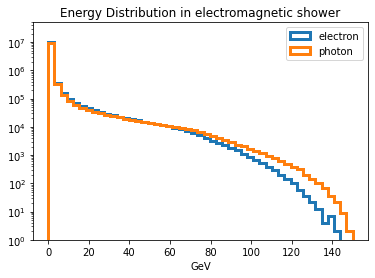

In [16]:
plt.hist(X_elec, bins=np.linspace(0, 150), histtype='step', label='electron', linewidth=3)
plt.hist(X_pho, bins=np.linspace(0, 150), histtype='step', label='photon', linewidth=3)
plt.legend()
plt.title('Energy Distribution in electromagnetic shower')
plt.xlabel('GeV')
plt.yscale('log')
plt.ylim(1, (50)*10**6)
plt.savefig('./images/hist/' + 'energy_deposits.png')
plt.show()

## Determine if Neural Networks can classify particles

Up to here, we have observed the followings:
1. Compared to etawidth, electrons and photons are not identical on the phiwidth histogram. <br />
    It is because electrons experience a magnetic field in the z-direction and are bended to $\phi$ direction.
    Therefore, the electrons enter the tracker with an angle while photons don't as they do not have charge.
    This difference appears on the phiwidth histogram. 
    
2. The histogram on energy deposits shows that photons have a harder tail (more energy). <br />
    Unlike photons, the electrons lose energy while interacting with a tracker. So, it is natural that photons have more energy than electrons, and it's shown on the histogram. 

As we have two datasets (shower features and energy deposit), we will, first, determine which dataset is suitable for a model to train on and investigate which architecture yields the best results by comparing the results from ANN, CNN, and ResNet. 

To start, we will configure three models:
1. Artificial NN (ANN) on features 
    - Because of the no / slight differences in features between photons and electrons, we would expect that the model cannot classify two particles well. 
2. ANN on energy deposits
    - Given that the electrons produce more energy than photons, we expect the model to classify the particles based on the energy. 
3. CNN on energy deposits
    - In general, CNN is considered a more powerful ANN architecture in terms of image analysis and classifications as CNN is a "feed-forward" network and spatial architecture while ANN is not. Similarly, we would expect CNN gives us better results contrasting to 2. 
    
    - We will also determine how the shallowness of the model affects the model performance by comparing two different deepness of the model. 
    
4. ResNet on energy deposits
    - ResNet is a shortcut version of CNN and overcomes a downside of CNN (vanishing gradients). It is powerful for image classifications, so we  expect that ResNet classifies better than CNN. 
    - Similar to CNN experiments, we will train the model only on energy deposits and examine how the number of layers influences the model performance. 